In [11]:
import torch
import torchvision

In [12]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class FilenameBasedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for img_name in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_name)
            if img_name.endswith(".jpg"):  # Check for jpg files
                label = img_name[0]  
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = ord(label) - ord('A') 

        return image, label


In [46]:
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations for training and testing
train_transform = transforms.Compose([
    transforms.Resize((140, 140)),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets and dataloaders
train_dataset = FilenameBasedDataset(root_dir='./TrainData', transform=train_transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = FilenameBasedDataset(root_dir='./TestData', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
len(train_dataset)

27455

In [47]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(train_dataset, [20000, 7455])
len(train_ds), len(val_ds)

(20000, 7455)

In [48]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
val_ds[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 10)

In [109]:
val_dataset = FilenameBasedDataset(root_dir='./Dataset/valid', transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


12


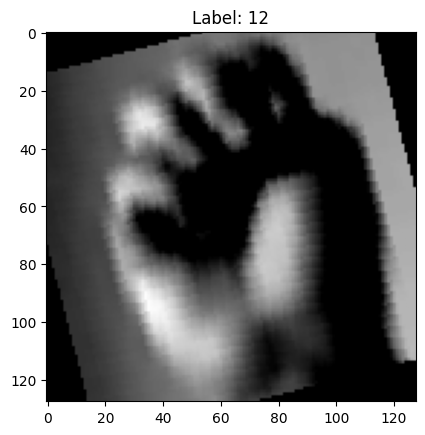

In [49]:
for brand_idx,(images, labels) in enumerate(train_loader):
    image = images[0]  
    label = labels[0].item()  
    print(label)
   
    image = image.permute(1, 2, 0).numpy()  

    if image.shape[2] == 1:
        image = image[:, :, 0]

    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()
    break

In [50]:
import torch.nn as nn
input_size = 3 * 128 * 128  
num_classes = 26  

In [51]:
class SignLanguage(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

model = SignLanguage()

In [52]:
import torch.nn.functional as F
loss_fn = F.cross_entropy

In [53]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [79]:
import torch.optim as optim
import torch.nn.functional as F
import torch

def fit(epochs, lr, model, train_loader, val_loader, opt_func=optim.Adam):
    optimizer = opt_func(model.parameters(), lr, weight_decay=1e-4)  # Added weight decay
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)
    history = []  # for recording epoch-wise results

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_acc = 0.0
        num_batches = 0

        # Training Loop
        for batch in train_loader:
            optimizer.zero_grad()  # Reset gradients

            loss, acc = model.training_step(batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc
            num_batches += 1

        # Average loss and accuracy for training
        avg_train_loss = train_loss / num_batches
        avg_train_acc = train_acc / num_batches

        # Validation
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            result = evaluate(model, val_loader)

        # Print and track the results
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}")
        print(f"Validation Loss: {result['val_loss']:.4f}, Validation Accuracy: {result['val_acc']:.4f}")
        
        model.epoch_end(epoch, result)
        history.append(result)

        scheduler.step()

    return history

# Assuming your model class, data loaders, etc. are set up correctly.


In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [81]:
def evaluate(model, val_loader):
    model.eval()
    outputs = []

    with torch.no_grad():
        for batch in val_loader:
            result = model.validation_step(batch)
            outputs.append(result)

    return model.validation_epoch_end(outputs)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class SignLanguageResNet(nn.Module):
    def __init__(self, num_classes, device):
        super(SignLanguageResNet, self).__init__()
        self.device = device
        
        # Load pre-trained ResNet18 model
        self.resnet = models.-(pretrained=True)
        
        # Replace the final fully connected layer to match the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
    def forward(self, xb):
        xb = xb.to(self.device)
        out = self.resnet(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        out = self(images)
        loss = nn.CrossEntropyLoss()(out, labels)
        acc = self.accuracy(out, labels)
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        out = self(images)
        loss = nn.CrossEntropyLoss()(out, labels)
        acc = self.accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': torch.tensor(acc)}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        correct = (preds == labels).sum().item()
        total = labels.size(0)
        return correct / total

# Initialize the model and move it to the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SignLanguageResNet(num_classes=26, device=device)
model.to(device)


/mnt/myssd/EDA and ML/Pytorch/SIGN LANGUAGE/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/myssd/EDA and ML/Pytorch/SIGN LANGUAGE/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/decoy/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 29.1MB/s]


SignLanguageResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [87]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 3.5060908794403076, 'val_acc': 0.035680290311574936}

In [88]:
for images, labels in test_loader:
    print(images.shape)
    break


torch.Size([32, 3, 128, 128])


In [89]:
history1 = fit(5, 0.01, model, train_loader, val_loader)

Epoch 1/5
Training Loss: 0.2108, Training Accuracy: 0.9370
Validation Loss: 0.0820, Validation Accuracy: 0.9732
Epoch [0], val_loss: 0.0820, val_acc: 0.9732
Epoch 2/5
Training Loss: 0.0477, Training Accuracy: 0.9858
Validation Loss: 0.0167, Validation Accuracy: 0.9946
Epoch [1], val_loss: 0.0167, val_acc: 0.9946
Epoch 3/5
Training Loss: 0.0454, Training Accuracy: 0.9868
Validation Loss: 0.0148, Validation Accuracy: 0.9949
Epoch [2], val_loss: 0.0148, val_acc: 0.9949
Epoch 4/5
Training Loss: 0.0321, Training Accuracy: 0.9906
Validation Loss: 0.0065, Validation Accuracy: 0.9984
Epoch [3], val_loss: 0.0065, val_acc: 0.9984
Epoch 5/5
Training Loss: 0.0244, Training Accuracy: 0.9938
Validation Loss: 0.0088, Validation Accuracy: 0.9973
Epoch [4], val_loss: 0.0088, val_acc: 0.9973


In [90]:
history2 = fit(5, 0.01, model, train_loader, val_loader)

Epoch 1/5
Training Loss: 0.0360, Training Accuracy: 0.9893
Validation Loss: 0.0200, Validation Accuracy: 0.9933
Epoch [0], val_loss: 0.0200, val_acc: 0.9933
Epoch 2/5
Training Loss: 0.0437, Training Accuracy: 0.9869
Validation Loss: 0.0238, Validation Accuracy: 0.9930
Epoch [1], val_loss: 0.0238, val_acc: 0.9930
Epoch 3/5
Training Loss: 0.0293, Training Accuracy: 0.9917
Validation Loss: 0.0123, Validation Accuracy: 0.9970
Epoch [2], val_loss: 0.0123, val_acc: 0.9970
Epoch 4/5
Training Loss: 0.0151, Training Accuracy: 0.9960
Validation Loss: 0.0174, Validation Accuracy: 0.9961
Epoch [3], val_loss: 0.0174, val_acc: 0.9961
Epoch 5/5
Training Loss: 0.0294, Training Accuracy: 0.9920
Validation Loss: 0.0159, Validation Accuracy: 0.9962
Epoch [4], val_loss: 0.0159, val_acc: 0.9962


In [91]:
history3 = fit(5, 0.01, model, train_loader, val_loader)

Epoch 1/5
Training Loss: 0.0264, Training Accuracy: 0.9929
Validation Loss: 0.0120, Validation Accuracy: 0.9965
Epoch [0], val_loss: 0.0120, val_acc: 0.9965
Epoch 2/5
Training Loss: 0.0176, Training Accuracy: 0.9956
Validation Loss: 0.0047, Validation Accuracy: 0.9987
Epoch [1], val_loss: 0.0047, val_acc: 0.9987
Epoch 3/5
Training Loss: 0.0301, Training Accuracy: 0.9914
Validation Loss: 0.0135, Validation Accuracy: 0.9965
Epoch [2], val_loss: 0.0135, val_acc: 0.9965
Epoch 4/5
Training Loss: 0.0148, Training Accuracy: 0.9963
Validation Loss: 0.0044, Validation Accuracy: 0.9984
Epoch [3], val_loss: 0.0044, val_acc: 0.9984
Epoch 5/5
Training Loss: 0.0209, Training Accuracy: 0.9939
Validation Loss: 0.0260, Validation Accuracy: 0.9926
Epoch [4], val_loss: 0.0260, val_acc: 0.9926


In [92]:
history4 = fit(5, 0.01, model, train_loader, val_loader)

Epoch 1/5
Training Loss: 0.0208, Training Accuracy: 0.9942
Validation Loss: 0.0096, Validation Accuracy: 0.9970
Epoch [0], val_loss: 0.0096, val_acc: 0.9970
Epoch 2/5
Training Loss: 0.0158, Training Accuracy: 0.9959
Validation Loss: 0.0282, Validation Accuracy: 0.9907
Epoch [1], val_loss: 0.0282, val_acc: 0.9907
Epoch 3/5
Training Loss: 0.0149, Training Accuracy: 0.9959
Validation Loss: 0.0004, Validation Accuracy: 1.0000
Epoch [2], val_loss: 0.0004, val_acc: 1.0000
Epoch 4/5
Training Loss: 0.0165, Training Accuracy: 0.9952
Validation Loss: 0.0066, Validation Accuracy: 0.9984
Epoch [3], val_loss: 0.0066, val_acc: 0.9984
Epoch 5/5
Training Loss: 0.0226, Training Accuracy: 0.9936
Validation Loss: 0.0039, Validation Accuracy: 0.9997
Epoch [4], val_loss: 0.0039, val_acc: 0.9997


In [93]:
history5 = fit(5, 0.01, model, train_loader, val_loader)

Epoch 1/5
Training Loss: 0.0185, Training Accuracy: 0.9948
Validation Loss: 0.0029, Validation Accuracy: 0.9996
Epoch [0], val_loss: 0.0029, val_acc: 0.9996
Epoch 2/5
Training Loss: 0.0099, Training Accuracy: 0.9972
Validation Loss: 0.0108, Validation Accuracy: 0.9970
Epoch [1], val_loss: 0.0108, val_acc: 0.9970
Epoch 3/5
Training Loss: 0.0155, Training Accuracy: 0.9960
Validation Loss: 0.0035, Validation Accuracy: 0.9988
Epoch [2], val_loss: 0.0035, val_acc: 0.9988
Epoch 4/5
Training Loss: 0.0126, Training Accuracy: 0.9964
Validation Loss: 0.0057, Validation Accuracy: 0.9987
Epoch [3], val_loss: 0.0057, val_acc: 0.9987
Epoch 5/5
Training Loss: 0.0164, Training Accuracy: 0.9953
Validation Loss: 0.0112, Validation Accuracy: 0.9964
Epoch [4], val_loss: 0.0112, val_acc: 0.9964


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

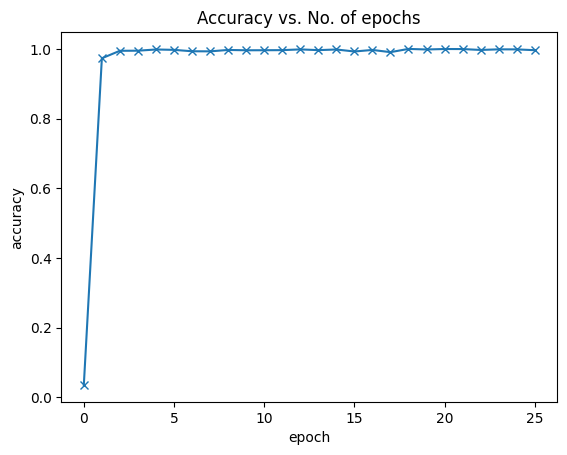

In [94]:
history = [result0] + history1 + history2 + history3 + history4+history5
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [95]:
def predict_image(img, model):
    img = img.to(model.device)
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()


Label: 20 , Predicted: 20


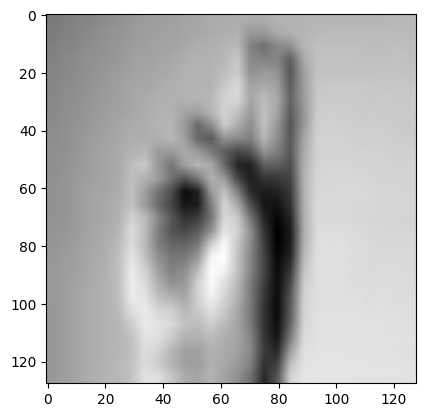

In [98]:
img, label = test_dataset[23]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))